# Quantitative Bitcoin Regression Using Neural Networks

This project looks at creating a regression model for Bitcoin the largest cryptocurrency. I have been interested in cryptocurrencies since I was 18 when I first bought BTC at $100. I will go over several topics in this project from a regular linear regression to using torch to create a Neural Network, to see if the model can be improved. The findings in this project are not financial advice.

## Summary of the Dataset

The dataset used was collected by a user on Kaggle. Originally I wanted to connect to CryptoQuant.com's API and use their data but they would not allow me to connect to their API for free. I found Kaggle's dataset interesting because it looked at some data that I think people would not correlate with Bitcoins price such as S&P 500 index or Oil prices. As of the end of February 2021 Bitcoin's price was approximately 50,000 USD and this dataset ends in April of 2020 when Bitcoin's price was approximately 6,000 USD.


https://www.kaggle.com/wojtekbonicki/bitcoin-data

### Load in libraries

One of the first steps is to load in the basic libraries that will be used. At first this project uses numpy, pandas, matplotlib, seaborn, and later sklearn and torch for the regression sections.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load in the data

Load in the csv data from Kaggle into Python, and look at the basic fields that have been created. This dataset contains Date, BTC price [USD], n-transactions, fee [USD], btc search trends, Gold price[USD], SP500 close index, Oil WTI price[USD], M2(Not seasonally adjusted)[1e+09 USD]. It starts in January 2014 and ends in April 2020.

In [2]:
btc = pd.read_csv('crypto_data/Bitcoin_dataset_updated.csv')
btc.head()

,Date,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
1,2014-01-03,781.23,60980.0,NaN,8,1238.4,1831.37,93.66,11089.3
2,2014-01-04,807.39,52052.0,NaN,8,NaN,NaN,NaN,11089.3
3,2014-01-05,828.74,58662.0,0.38,8,NaN,NaN,NaN,11089.3
4,2014-01-06,904.98,67358.0,NaN,8,1237.8,1826.77,93.12,11089.3


### Find Nulls and clean up data

Next clean up the data by removing nulls, and drop the Date as it is not a continuous variable. 

In [3]:
btc.isnull().sum()

Date                                        0
BTC price [USD]                             0
n-transactions                              0
fee [USD]                                 844
btc search trends                           0
Gold price[USD]                           639
SP500 close index                         718
Oil WTI price[USD]                        723
M2(Not seasonally adjusted)[1e+09 USD]      0
dtype: int64

In [4]:
btc = btc.drop(['Date'], axis=1) #drop the data

#I created a function to clean up the data and remove any Na's

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), 'df needs to be a pd.DataFrame'
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(btc)

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,749.27,54770.0,0.18,8.0,1225.0,1831.98,95.14,11089.3
6,790.00,61439.0,0.18,8.0,1225.3,1837.49,91.90,11089.3
12,823.00,57378.0,0.22,8.0,1245.2,1838.88,92.15,11089.3
15,817.15,59026.0,0.19,8.0,1251.7,1838.70,93.96,11089.3
21,819.62,63576.0,0.19,8.0,1262.6,1828.46,97.23,11089.3
...,...,...,...,...,...,...,...,...
2303,7130.99,329045.0,0.91,16.0,1745.4,2797.80,15.06,17269.8
2304,7477.60,320055.0,0.87,16.0,1735.6,2836.74,15.99,17269.8
2307,7699.27,311217.0,0.69,16.0,1723.8,2878.48,12.17,17269.8
2308,7790.66,323475.0,0.66,16.0,1722.2,2863.39,12.40,17269.8


## Exploratory Data Analysis (EDA)

Creating simple plots to check out the data and understand some of the relationships between the different variables.

### Basic statistical info

Using .describe() some basic statistics can be presented from the numeric values in the dataset.

In [5]:
btc.describe()

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
count,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000
mean,5352.851926,254421.630739,2.230409,15.163673,1369.540319,2584.999880,57.670948,13867.278842
std,3892.224190,88589.954049,5.568724,15.852566,114.562397,383.177031,15.852663,1274.266180
min,172.000000,54142.000000,0.030000,2.000000,1097.700000,1755.200000,-36.980000,11089.300000
25%,884.052500,207520.500000,0.230000,6.000000,1293.550000,2265.067500,49.545000,13293.800000
50%,5895.335000,267637.500000,0.700000,13.000000,1345.650000,2672.275000,56.285000,14024.000000
75%,8171.610000,322157.500000,1.767500,17.750000,1420.275000,2864.117500,63.950000,14584.100000
max,18911.790000,490644.000000,54.790000,100.000000,1768.900000,3386.150000,107.950000,17269.800000


### Pairwise Plot

Plot pairwise relationships in a dataset. By default, this function will create a grid of Axes such that each numeric variable in the data will be shared across the y-axes across a single row and the x-axes across a single column. Looking at the first row which is price it can already be seen that there are positive correlations between many of the fields.

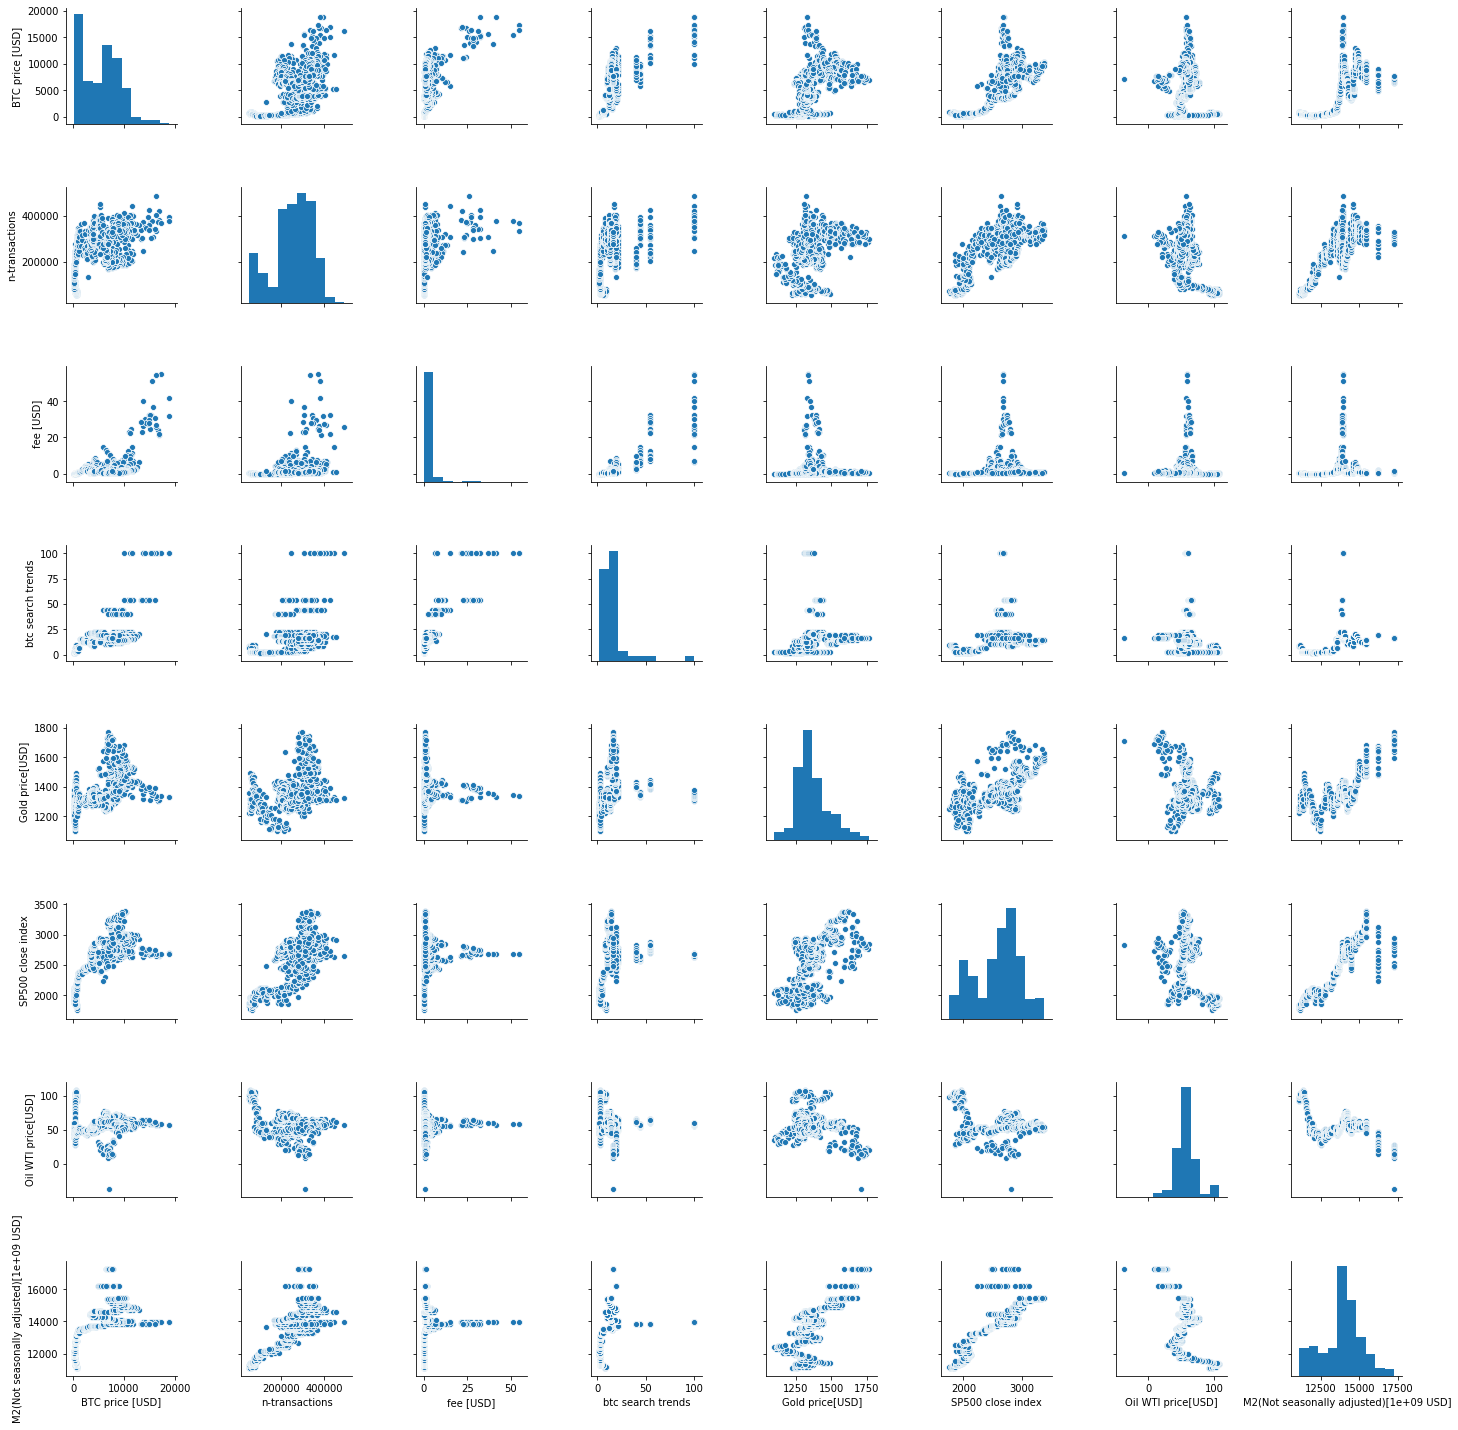

In [6]:
sns.pairplot(btc)

### Distribution of Bitcoin's price

Bitcoins price skews to the left because much of the time its price was in the $100s. Real world data is not always evenly distributed.

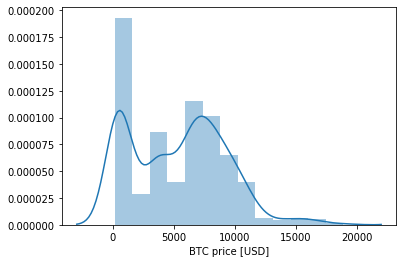

In [7]:
sns.distplot(btc['BTC price [USD]'])

### Correlations

The correlations of the dataset can help understand the relationships between variables. The largest correlations are seen between price and the google search trends, S&P 500 and the M2 money supply. Which to me indcates that Bitcoin is closely related to capital markets. Also since the capital markets are priced in dollars, the M2 has a big influence on both the stock market and bitcoin. Devaluing the dollar will increase their prices in dollars. Since some of the variables are correlated with each other this may cause issues of multicollinearity, however features will not be dropped in this report.

In [8]:
btc.corr()

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
BTC price [USD],1.000000,0.596925,0.517846,0.677435,0.523268,0.792344,-0.004852,0.678480
n-transactions,0.596925,1.000000,0.273090,0.384363,0.376860,0.720957,-0.420285,0.771463
fee [USD],0.517846,0.273090,1.000000,0.834244,0.011837,0.116217,-0.000592,0.054859
btc search trends,0.677435,0.384363,0.834244,1.000000,0.142426,0.289335,-0.029324,0.237495
Gold price[USD],0.523268,0.376860,0.011837,0.142426,1.000000,0.557169,-0.196017,0.676179
SP500 close index,0.792344,0.720957,0.116217,0.289335,0.557169,1.000000,-0.104263,0.864312
Oil WTI price[USD],-0.004852,-0.420285,-0.000592,-0.029324,-0.196017,-0.104263,1.000000,-0.439634
M2(Not seasonally adjusted)[1e+09 USD],0.678480,0.771463,0.054859,0.237495,0.676179,0.864312,-0.439634,1.000000


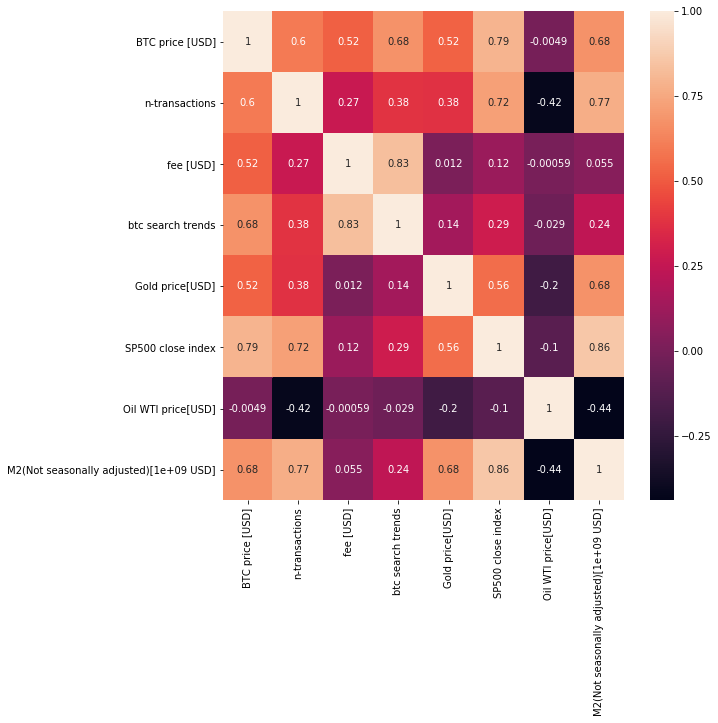

In [9]:
fig, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(btc.corr(), annot=True)

## Start Regression

The first steps in starting a regression is to split up the features (X) and what we are predicting (Y). Use sklearn's Linear Regression and split the training and test data up, split it up by 80%.

In [10]:
btc.columns.values.tolist() #Used to easily grab column names

['BTC price [USD]',
 'n-transactions',
 'fee [USD]',
 'btc search trends',
 'Gold price[USD]',
 'SP500 close index',
 'Oil WTI price[USD]',
 'M2(Not seasonally adjusted)[1e+09 USD]']

In [11]:
#Split X and Y

X = btc[['n-transactions', 'fee [USD]', 'btc search trends',
               'Gold price[USD]', 'SP500 close index','Oil WTI price[USD]'
                     ,'M2(Not seasonally adjusted)[1e+09 USD]']]

y = btc['BTC price [USD]']

In [12]:
#Import train_test_split function from sklearn.model_selection

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression 

A Linear Regression fits a linear model with coefficients b = (b1, …, bp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Using the training data to fit the model we will be able to find the intercept and coefficients.


$$E(y) = \alpha + \beta{x}$$ 

In [13]:
#Import LinearRegression function from sklearn.model_selection
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

In [14]:
#Train the Linear Regression Classifer
lm.fit(X_train,y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
#Print the intercept
print(lm.intercept_)

-22726.75925317467


In [16]:
#Find the Coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
n-transactions,-0.004830
fee [USD],106.888668
btc search trends,91.674310
Gold price[USD],3.866818
SP500 close index,5.701102
Oil WTI price[USD],25.229473
M2(Not seasonally adjusted)[1e+09 USD],0.448872


In [17]:
# Predict values based on linear model object.
predictions = lm.predict(X_test)

### Scatter Plot of Predicted Price versus Actual Price

Below is a scatter plot of the Predicted Bitcoin prices on the Y axis and the Actual Bitcoin price on the X. This is used to see how well the model is doing. Overall it is a satisfactory model as it has a very positive correlation. This model could be improved. At lower values some of the predicted prices are negative which is impossible. Regplot by seaborn is used which plots the regression of the Predicted vs Actual. Remember this line is NOT our model's regression line.

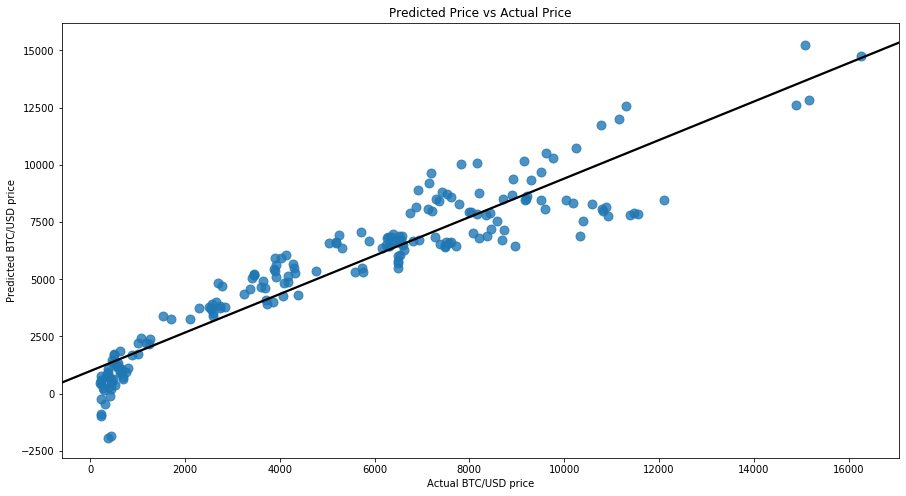

In [18]:
plt.figure(figsize=(15, 8))

sns.regplot(x=y_test, y=predictions, ci=None, scatter_kws={"s": 80},line_kws = {'color': 'black'})

plt.xlabel("Actual BTC/USD price")
plt.ylabel("Predicted BTC/USD price")

plt.title("Predicted Price vs Actual Price")

plt.show()

### Residual Histogram

A residual histogram is used for univariant set of observations and visualizes it through a histogram i.e. only one observation
and hence we choose one particular column of the dataset. The histogram is much more evenly distrubed than price originally and this is a good sign for the Regression.

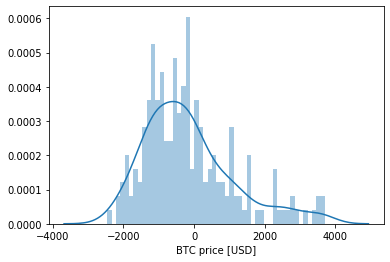

In [19]:
sns.distplot((y_test-predictions),bins=50);

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

**Coefficient of Determination** shows how much of the variation of the dependent variable y can be explained by the model, here we want to see how close it is to 1:

$$R^2 =1 - \frac {\sum_{i=1}^n(e^2_i)}{ \sum_{i=1}^n(y_i-\hat{y}_i)^2}$$


In [20]:
# Importing metrics from sklearn and R^2 score
from sklearn import metrics
from sklearn.metrics import r2_score

In [21]:
# Show the values of MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1010.7904070175384
MSE: 1644311.0769348578
RMSE: 1282.30693554034


In [22]:
r2_score(y_test, predictions)

0.8813665318426269

### Comparing sklearn to statmodel

Another library is statsmodel, it can be seen that it resulted in the same coefficients. It also also shows all the coefficients are statistically significant. The results also found that there is strong multicollinearity as indicated above.

In [23]:
X = np.column_stack((X_train['n-transactions'],X_train['fee [USD]'], X_train['btc search trends'],
               X_train['Gold price[USD]'], X_train['SP500 close index'],X_train['Oil WTI price[USD]']
                     ,X_train['M2(Not seasonally adjusted)[1e+09 USD]']))

y = y_train

In [24]:
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        BTC price [USD]   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     806.3
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:58:54   Log-Likelihood:                -6927.3
No. Observations:                 801   AIC:                         1.387e+04
Df Residuals:                     793   BIC:                         1.391e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.273e+04   1004.364    -22.628      0.0

### Checking model on Bitcoin's price today

I googled these different features on 2/24/2021 to see what the predicted price will be.

In [25]:
df2 = pd.DataFrame([['2021-2-24',50506.16, 358092, 26.36, 70, 1796.00, 3925.43, 63.41, 19395.30]], columns=['Date','BTC price [USD]','n-transactions',
                                                      'fee [USD]', 'btc search trends' ,'Gold price[USD]'  ,'SP500 close index' , 
                                                         'Oil WTI price[USD]'  ,'M2(Not seasonally adjusted)[1e+09 USD]'  ])



df2

,Date,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,2021-2-24,50506.16,358092,26.36,70,1796.0,3925.43,63.41,19395.3


In [26]:
n = (coeff_df.iloc[0] * df2['n-transactions'].iloc[0])
fee = (coeff_df.iloc[1] * df2['fee [USD]'].iloc[0])
search = (coeff_df.iloc[2] * df2['btc search trends'].iloc[0])
gold = (coeff_df.iloc[3] * df2['Gold price[USD]'].iloc[0])
sp500 = (coeff_df.iloc[4] * df2['SP500 close index'].iloc[0])
oil = (coeff_df.iloc[5] * df2['Oil WTI price[USD]'].iloc[0])
M2 = (coeff_df.iloc[6] * df2['M2(Not seasonally adjusted)[1e+09 USD]'].iloc[0])


price = (lm.intercept_ + n + fee + search + gold + sp500 + oil + M2 )
print("On 2-24-2021 Bitcion's Predicted Price", int(price) , "vs Actual Price" , int(df2['BTC price [USD]'].iloc[0]))

On 2-24-2021 Bitcion's Predicted Price 24408 vs Actual Price 50506


## First Model Conclusion

With an R squared of .88 the model is good for a small dataset and for different variables that are not normally associated with Bitcoin's price. As seen above the predicted price is below the actual, but at the highest of the predicted prices based on the dataset used. The model is not saying whether BTC is overvalued or not. This is a small dataset, and there are other features that could be missing. Also, the data is missing the past 8 months. The model will be improved below if possible.

## Using torch to do Neural Networks Regression

To determine if the model could be improved use torch, a library in python. A neural network regression will be able to learn and improve the model. First step is to scale the X variables with sklearn's preprocessing. To read more about neural networks use the link below.

https://en.wikipedia.org/wiki/Artificial_neural_network

In [27]:
from sklearn import preprocessing
names = ['n-transactions', 'fee [USD]', 'btc search trends',
               'Gold price[USD]', 'SP500 close index','Oil WTI price[USD]'
                     ,'M2(Not seasonally adjusted)[1e+09 USD]']

for x in names:

    btc[x] = preprocessing.scale(btc[x])

btc.describe()

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
count,1002.000000,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03,1.002000e+03
mean,5352.851926,1.345121e-16,-7.997041e-16,-4.556679e-18,7.281822e-16,8.246896e-16,-4.254747e-17,8.624727e-16
std,3892.224190,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00,1.000499e+00
min,172.000000,-2.261878e+00,-3.953343e-01,-8.307959e-01,-2.374043e+00,-2.166660e+00,-5.973647e+00,-2.181150e+00
25%,884.052500,-5.296825e-01,-3.594015e-01,-5.783448e-01,-6.636407e-01,-8.353636e-01,-5.128480e-01,-4.502711e-01
50%,5895.335000,1.492547e-01,-2.749595e-01,-1.365554e-01,-2.086396e-01,2.278808e-01,-8.747049e-02,1.230508e-01
75%,8171.610000,7.649817e-01,-8.316812e-02,1.632303e-01,4.430775e-01,7.287937e-01,3.962859e-01,5.628174e-01
max,18911.790000,2.667801e+00,9.443067e+00,5.354256e+00,3.487699e+00,2.091853e+00,3.173231e+00,2.671514e+00


In [28]:
X = btc[['n-transactions', 'fee [USD]', 'btc search trends',
               'Gold price[USD]', 'SP500 close index','Oil WTI price[USD]'
                     ,'M2(Not seasonally adjusted)[1e+09 USD]']]
X

,n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,-2.254785,-0.368385,-0.452119,-1.262303,-1.966182,2.364761,-2.181150
6,-2.179468,-0.368385,-0.452119,-1.259683,-1.951795,2.160277,-2.181150
12,-2.225332,-0.361198,-0.452119,-1.085892,-1.948166,2.176055,-2.181150
15,-2.206720,-0.366588,-0.452119,-1.029126,-1.948636,2.290289,-2.181150
21,-2.155334,-0.366588,-0.452119,-0.933934,-1.975373,2.496666,-2.181150
...,...,...,...,...,...,...,...
2303,0.842766,-0.237230,0.052783,3.282468,0.555635,-2.689279,2.671514
2304,0.741237,-0.244417,0.052783,3.196882,0.657309,-2.630584,2.671514
2307,0.641424,-0.276756,0.052783,3.093830,0.766295,-2.871673,2.671514
2308,0.779861,-0.282146,0.052783,3.079857,0.726894,-2.857158,2.671514


### Split the data again

Import torch and resplit the data into training and test set. As in the first regression the training data will be 80%.

In [29]:
import torch

In [30]:
y = btc[['BTC price [USD]']] #Reshape y to work with torch
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train_tensor = torch.tensor(X_train2.values, dtype = torch.float)
X_test_tensor = torch.tensor(X_test2.values, dtype = torch.float)

y_train_tensor = torch.tensor(y_train2.values, dtype = torch.float)
y_test_tensor = torch.tensor(y_test2.values, dtype = torch.float)

In [32]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([801, 7]), torch.Size([801, 1]))

### Define the parameters for the neural network
* <b>inp</b> sets the input size to 7 to match the shape of the X_train_tensor. With the one-hot-encoding, we have multiple columns in our X data
* <b>out</b> will be used to set the size of the output from the neural network. We only predict a single price for each car, so this will be 1
* <b>hid</b> is used to set the number of hidden layers in our neural network
* <b>loss_fn</b> is MSELoss since we're performing a linear regression
* <b>learning_rate</b> is set to 0.0001

In [33]:
inp = 7
out = 1

hid = 100

loss_fn = torch.nn.MSELoss()

learning_rate = 0.0001

<b>nn.Sequential:</b>
Use the nn package to define our model as a sequence of layers. nn.Sequential is a Module which contains other Modules, and applies them in sequence to produce its output. Each Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.

<b>nn.Linear: </b> Applies a linear transformation to the incoming data: y=Ax+b<br>
parameters:<br>
in_features – size of each input sample
out_features – size of each output sample
bias – If set to False, the layer will not learn an additive bias. Default: True

<b>Sigmoid : </b>Applies the element-wise function Sigmoid(x)= 1 / (1+exp(−x))

#### Creating model using nn.Sequential( )

In [34]:
model = torch.nn.Sequential(torch.nn.Linear(inp, hid),
                            torch.nn.ReLU(),
                            torch.nn.Linear(hid, out))

### Training Model
Foward Pass:
* Predicting Y with input data X

Finding Loss:
* Finding difference between Y_train_tensor and Y_pred using MSEloss function defined above


Back Propogation:
* starting with zero gradients before back propogation
* back propogation is done by simply loss.backward() function

Manually updating model parameters
* weights have requires_grad=True, but we don't need to track this in autograd. So will wrap it in torch.no_grad
* model.parameter() returns all the weights and biases of parameters
* reducing weight with multiple of learning rate and gradient

In [35]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
loss_values = []
for iter in range(100000):
    
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)

    if iter % 5000 ==0:
        print(iter, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    running_loss =+ loss.item() * len(X_train_tensor)

    loss_values.append(running_loss / len(X_train_tensor))

0 44563208.0
5000 42965216.0
10000 39119428.0
15000 33810104.0
20000 27641110.0
25000 21318282.0
30000 15638183.0
35000 11309038.0
40000 8479966.0
45000 6453796.5
50000 4984101.0
55000 3819618.5
60000 2985630.75
65000 2415338.0
70000 2012668.625
75000 1797537.125
80000 1734861.375
85000 1707073.25
90000 1690475.125
95000 1681492.5


### Plotting loss Curve

Plotting the loss curve shows if the NN ran any longer it could overfit the model. This could cause issues predicting future data points.

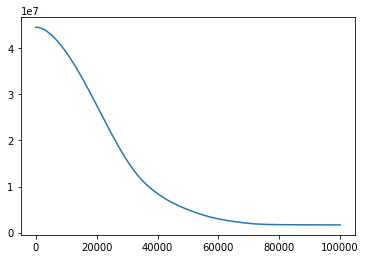

In [37]:
plt.plot(loss_values)

### Using our model for predictions
Pick one of the locations from the test data set for prediction of BTC price. Then convert these features to a Pytorch tensor. 

In [38]:
sample = X_test2.iloc[14]
sample

n-transactions                            0.903628
fee [USD]                                -0.303706
btc search trends                        -0.136555
Gold price[USD]                           1.958511
SP500 close index                         1.672438
Oil WTI price[USD]                       -0.384414
M2(Not seasonally adjusted)[1e+09 USD]    1.219837
Name: 2220, dtype: float64

In [39]:
sample_tensor = torch.tensor(sample.values, 
                             dtype = torch.float)
sample_tensor

tensor([ 0.9036, -0.3037, -0.1366,  1.9585,  1.6724, -0.3844,  1.2198])

In [40]:
#Compare the actual and predicted BTC price
y_pred = model(sample_tensor)

print("Predicted BTC/USD price: ", int(y_pred.item()))
print("Actual BTC/USD price: ", int(y_test.iloc[23]))

Predicted BTC/USD price:  9928
Actual BTC/USD price:  7713


### Performing predictions on the entire test set
Get the list of predicted values in a tensor, then tensor is converted to a numpy array.

In [41]:
y_pred_tensor = model(X_test_tensor)

y_pred_tensor[:5]

tensor([[ 6733.1475],
        [ 6628.0522],
        [ 8164.8384],
        [ 3944.3340],
        [15333.7363]], grad_fn=<SliceBackward>)

In [42]:
y_pred = y_pred_tensor.detach().numpy()

y_pred[:5]

array([[ 6733.1475],
       [ 6628.0522],
       [ 8164.8384],
       [ 3944.334 ],
       [15333.736 ]], dtype=float32)

### Scatter Plot of Predicted Price versus Actual Price

The new scatter plot also has a strong positive correlation. Also this improved model no longer predicted negative values. This already seems to be improved from a first look. Remember this line is NOT our model's regression line.

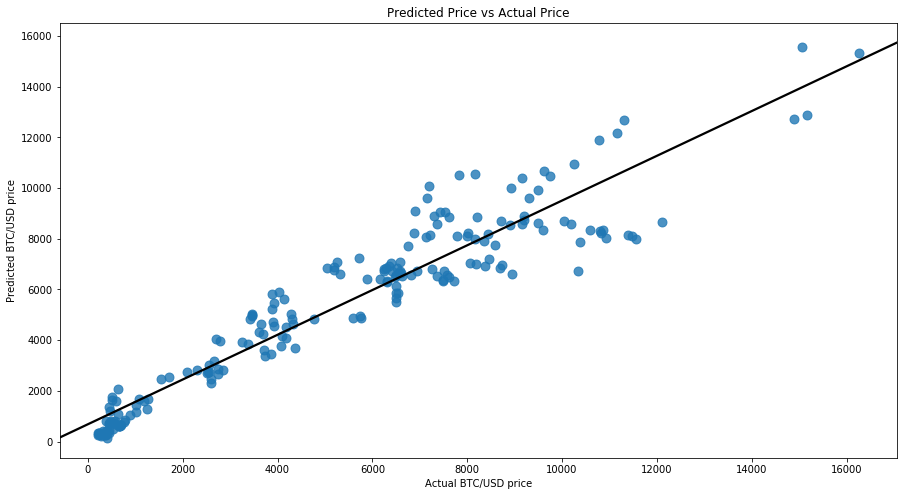

In [43]:
plt.figure(figsize=(15, 8))

sns.regplot(x=y_test2, y=y_pred, ci=None, scatter_kws={"s": 80},line_kws = {'color': 'black'})

plt.xlabel("Actual BTC/USD price")
plt.ylabel("Predicted BTC/USD price")

plt.title("Predicted Price vs Actual Price")

plt.show()

### New Regression Evaluation Metrics

In [44]:
r2_score(y_test2, y_pred)

0.9038028538302127

In [45]:
# Show the values of MAE, MSE, RMSE
print('MAE:', metrics.mean_absolute_error(y_test2,  y_pred))
print('MSE:', metrics.mean_squared_error(y_test2,  y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test2,  y_pred)))

MAE: 820.8824820933175
MSE: 1333333.9695225973
RMSE: 1154.7008138572508


## Conclusion

The Neural Net improved the R^2 by 2% which is a notable improvement. With a R^2 of 90.3%, this model fits well but could still be improved. If more features such as the number of active Bitcoin addresses were added and the data was over a longer time frame with less nulls, an even more accurate model could be created. The goal of building a quantitative model for BTC's price was achieved. Since it is not a traditional asset that has cash flow or dividends, other ways to value it were tested.

Thank you for reading through this project. Please reach out to me, if you have any questions or concerns.